In [13]:
!pip install nibabel tqdm scikit-image

You should consider upgrading via the 'c:\users\bch96\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [14]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [15]:
#GPU 확인
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6803364713423301532
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914163099
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4183100783847002060
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


True

In [16]:
def image_normalization(img):
    x_min = np.min(img)
    if(x_min >=0.0):
        img = img - np.mean(img)
    return img

In [17]:
def get_mask_data():

    x_train_path = "dataset/x_train.npy"
    x_val_path = "dataset/x_val.npy" 
    y_train_path = "dataset/y_train.npy"
    y_val_path = "dataset/y_val.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
    for i, x in enumerate(x_train):
        x = image_normalization(x)

    for i, x in enumerate(x_val):
        x = image_normalization(x)
        
    return x_train, y_train, x_val, y_val


In [18]:
def mask_model(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 8
    kernel_size = 3
    copy_layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
        net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
        copy_layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        filters = filters*2
    ff2 = 256
  
    #bottleneck 
    j = len(copy_layers) - 1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    filters = filters/2
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    j = j -1 

    #upsampling 
    for i in range(0, 5):
        net = Conv2D(filters, 3, activation='relu', padding='same') (net)
        net = Conv2D(filters, 3, activation='relu', padding='same') (net)
        print(net.shape)
        filters = filters/2
        net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, copy_layers[j]])
        j = j -1 
    
  
    #classification 
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(1, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'mse', tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [19]:
def training_model(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
#     ax[2,0].set_title('MeanIoU')
#     ax[2,0].plot(history.history['mean_io_u_67'], 'r')
#     ax[2,1].set_title('val_MeanIoU')
#     ax[2,1].plot(history.history['val_mean_io_u_67'], 'r')

    preds = model.predict(x_val)

    fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
    temp = np.empty((256, 256, 1), dtype=np.float32)

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
        ax[i, 0].title.set_text(str(i))
        ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
        ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        temp = x_val[i]
        pred_sum = preds[i][preds[i] > 0]
        pred_mean = np.mean(pred_sum)
        if(np.min(temp) >= 0) :
            temp[preds[i] < pred_mean] = 0
        else :
            temp[preds[i] < pred_mean] = -2048
        ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(1720, 256, 256, 1) (1720, 256, 256, 1)
(192, 256, 256, 1) (192, 256, 256, 1)
(None, 8, 8, 256)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 64, 64, 32)
(None, 64, 64, 32)
(None, 128, 128, 16)
(None, 128, 128, 16)
(None, 256, 256, 8)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 8)  584         conv2d_54[0][0]                  
________________

108/108 [==============================] - 33s 252ms/step - loss: 0.2506 - acc: 0.8610 - mse: 0.0158 - mean_io_u_2: 0.4984 - val_loss: 0.0220 - val_acc: 0.8833 - val_mse: 6.7574e-04 - val_mean_io_u_2: 0.5000
Epoch 2/20
108/108 [==============================] - 26s 241ms/step - loss: 0.0211 - acc: 0.8739 - mse: 7.6524e-04 - mean_io_u_2: 0.5000 - val_loss: 0.0142 - val_acc: 0.8836 - val_mse: 5.1421e-04 - val_mean_io_u_2: 0.5000
Epoch 3/20
108/108 [==============================] - 26s 240ms/step - loss: 0.0118 - acc: 0.8742 - mse: 1.9686e-04 - mean_io_u_2: 1.0000 - val_loss: 0.0094 - val_acc: 0.8837 - val_mse: 2.8195e-04 - val_mean_io_u_2: 1.0000
Epoch 4/20
108/108 [==============================] - 26s 240ms/step - loss: 0.0094 - acc: 0.8742 - mse: 9.3684e-05 - mean_io_u_2: 0.5000 - val_loss: 0.0061 - val_acc: 0.8837 - val_mse: 8.2010e-06 - val_mean_io_u_2: 1.0000
Epoch 5/20
108/108 [==============================] - 26s 239ms/step - loss: 0.0089 - acc: 0.8742 - mse: 5.7060e-05 - mean_

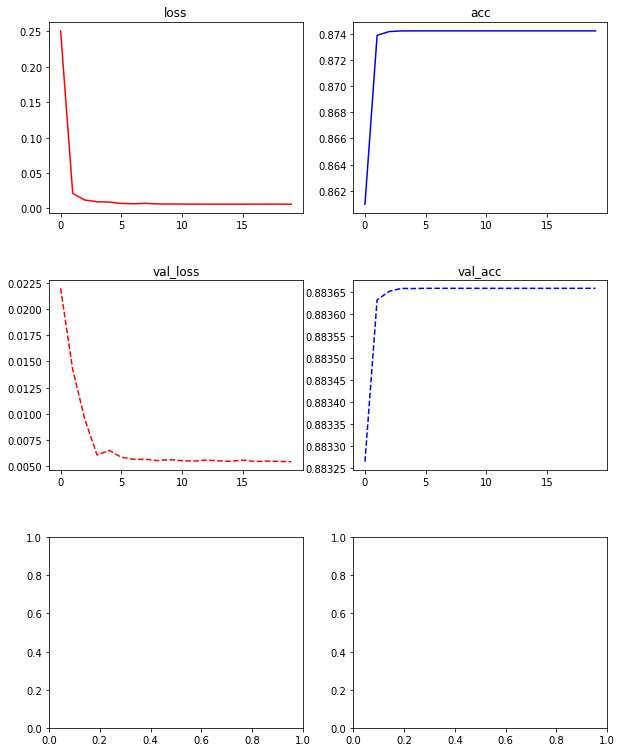

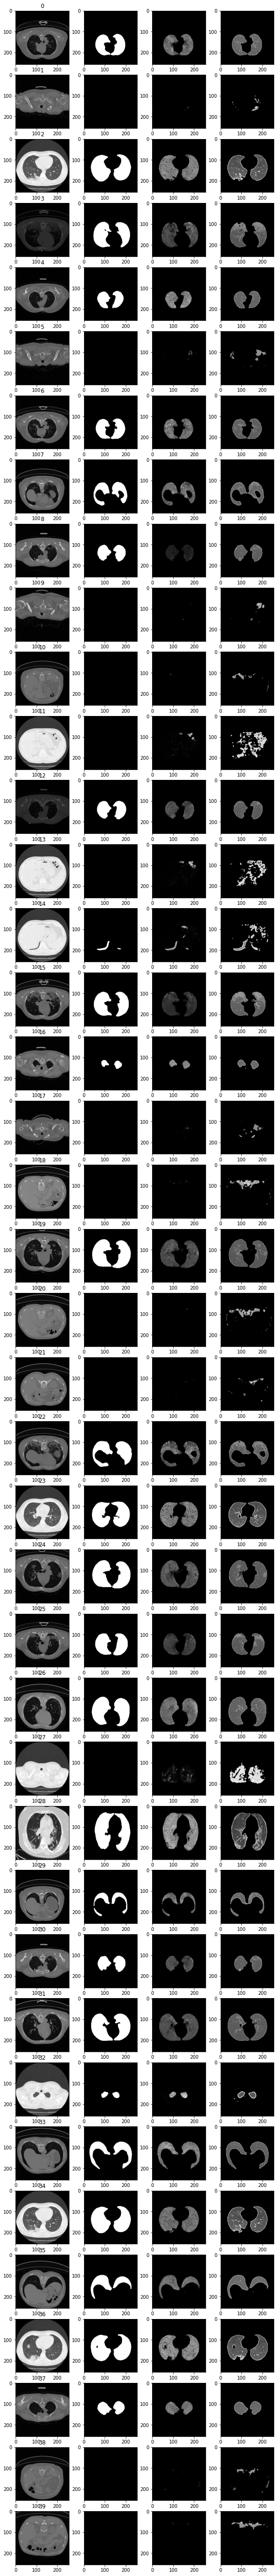

In [20]:
x_train, y_train, x_val, y_val = get_mask_data()
model = mask_model(x_train, y_train, x_val, y_val)
history = training_model(model,x_train, y_train, x_val, y_val)

[[  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [125.892166]
 [132.18591 ]
 [112.59547 ]
 [ 99.95733 ]
 [106.04327 ]
 [105.59875 ]
 [104.96324 ]
 [107.70931 ]
 [121.86866 ]
 [117.49617 ]
 [122.222725]
 [113.63982 ]
 [117.987114]
 [109.70129 ]
 [105.805786]
 [126.24907 ]
 [129.06482 ]
 [120.12154 ]
 [118.593605]
 [113.

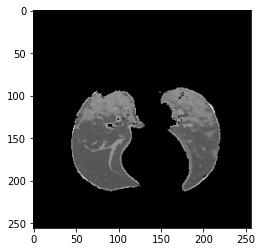

In [23]:
#실험적으로 값 맞춰주기
# temp = x_val[3]
# temp = temp/2048
# temp = temp + 1
# temp = temp * 255
# temp = temp /2
# print(temp[120])
# print(np.max(temp))
# plt.imshow(temp.squeeze(), cmap = "gray")